# Abstract

When implementing and applying machine learning models to problems, it is imperative that we understand the potential for disparate impacts on people. For example, if a machine learning model were used by a company in their hiring process, and that model demonstrated bias towards certain races over others, that would yield unfair outcomes. In this blog post, a model will be trained which predicts the employment status of individuals based on census data taken in Tennessee in 2018. The model will then be audited for racial bias, with examinations of the prediction rates across racial categories, and a statistical examination of whether the model is fair or not. 

# Data

For this audit, we will use data from the `folktables` library. The following code block imports census data from Tennessee in 2018. It then filters it down to the list of features we will use in our model. In this data, RAC1P is the racial group of the respondent, which we will not use in training the model, so that it will be theoretically blind to race (though it may still exhibit bias). ESR is the employment status of the respondent, which is the target variable. Other notable features include age, level of education, marital status, and indicators of any disabilities in sight, hearing, or cognitive ability.

In [61]:
from folktables import ACSDataSource, BasicProblem
import numpy as np

STATE = "TN"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
acs_data[possible_features].head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,72,5.0,5,16,1,NaN,1,1.0,4.0,4,1,2,2,2.0,1,1,6.0
1,41,18.0,5,16,1,NaN,1,1.0,4.0,1,1,2,1,1.0,1,1,6.0
2,18,18.0,5,17,2,NaN,1,3.0,4.0,1,1,2,2,2.0,2,1,6.0
3,26,16.0,5,16,2,NaN,1,3.0,4.0,2,1,2,2,2.0,1,1,6.0
4,78,20.0,3,16,1,NaN,1,1.0,4.0,4,1,2,2,2.0,2,1,6.0


Now, we will establish a BasicProblem from the data, which will define the problem which we will solve with our eventual model. First, we will define a list of features which does not include race or employment, as we will not use those features in training the model. Then, we will create a BasicProblem which uses that set of features, has employment as the target, and race as the group variable.

In [5]:
features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]

EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

As a final preprocessing step, we will perform a train test split, so that we don't train on all of the data, and can ensure that the model generalizes effectively to new data. The following code block performs this split; the subsequent code block converts the data into a pandas dataframe, which will be convenient for taking a look at the data before training the model.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

In [62]:
import pandas as pd
df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train
df.head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,group,label
0,4.0,1.0,5.0,2.0,2.0,2.0,5.0,1.0,0.0,1.0,2.0,2.0,2.0,0.0,1.0,1,False
1,47.0,19.0,1.0,0.0,1.0,0.0,1.0,1.0,4.0,3.0,1.0,2.0,2.0,2.0,1.0,1,False
2,35.0,20.0,1.0,0.0,2.0,0.0,1.0,3.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,1,True
3,42.0,16.0,3.0,0.0,2.0,0.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1,True
4,73.0,19.0,1.0,1.0,2.0,0.0,1.0,1.0,4.0,4.0,1.0,2.0,2.0,2.0,1.0,2,False


Now let's get an idea of the scale of our data, and some of the trends we may observe regarding employment status. The following code block prints the total number of respondents, the total number of employed respondents, and then a breakdown of those metrics by race group.

In [64]:
print("Number of individuals in dataframe:", df.shape[0]) 
print("Number of employed individuals:", df["label"].sum())
print("Number of individuals by race", df.groupby("group").size()) # 1 = white, 2 = black, 3 = other self identified race
print("Employment rate by race", df[df['label']].groupby('group').size() / df.groupby('group').size())
print("Employment rate for all self-identified categories:", df[df['group'] >= 3]['label'].mean())

Number of individuals in dataframe: 54360
Number of employed individuals: 24060
Number of individuals by race group
1    44911
2     6717
3       80
4        2
5       30
6      880
7       31
8      630
9     1079
dtype: int64
Employment rate by race group
1    0.449244
2    0.416853
3    0.437500
4    1.000000
5    0.366667
6    0.464773
7    0.354839
8    0.465079
9    0.299351
dtype: float64
Employment rate for all self-identified categories: 0.3967789165446559


As we can see, there is data for 54,360 respondents, 24,060 of which are employed, yielding an overall employment rate of **44.26%**. Of those 54,360 individuals, 44,911 are white (group 1), 6,717 are black (group 2), and 2,732 are of other self-identified racial categories (groups 3-9). The employment rate averages out to 44.9244% for white respondents, 41.6853% for black respondents, and 39.6779% across all other categories. To get a more indepth understanding of these categories, let's take a look at employment rate not only by race, but also sex. The following code block generates a bar chart showing the employment rate within each racial group, also filtered by sex.

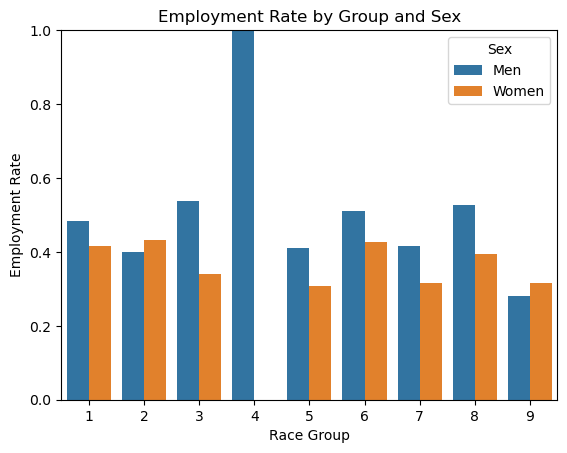

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

rate_df = (
    df.groupby(['group', 'SEX'])['label']
    .mean()
    .reset_index()
)

rate_df['SEX'] = rate_df['SEX'].map({1: 'Men', 2: 'Women'}) # For readability

sns.barplot(data=rate_df, x='group', y='label', hue='SEX')

plt.ylabel('Employment Rate')
plt.xlabel('Race Group')
plt.title('Employment Rate by Group and Sex')
plt.ylim(0, 1)
plt.legend(title='Sex')

plt.show()

Employment rate is higher for white men than women, but higher for black women than black men. Across other racial groups, the general trend is that males have a higher employment rate, with the exception being people with two or more races, where females have higher rates. Overall, though, there are scarcely differences of more than 8% in categories with sufficient sample sizes (category 4, alaskan natives, shows a large disparity since there were only 2 respondents).

# Modeling

Now it is time to train a model. I chose to go with the Support Vector Classifier, which aims to make classifications by finding a hyperplane which maximizes the distance between groups. The regularization parameter C is of key interest, as it specifies the model's tolerance for misclassification. With a lower value of C, the model will be more willing to misclassify outliers if the hyperplane can be more distant between groups; with a larger value of C, misclassifications are punished more harshly. To tune this parameter, I will use a grid search in combination with cross validation. The grid search computes scores for X_train on a range of potential C values, performing 5-fold cross validation each time. The `n_jobs` parameter allows the grid search to take advantage of parallel computing-- by setting it to -1, it will use all available cores for computation, minimizing the running time. At the end, the grid search will have the best C value and best accuracy stored in the `best_params_` array and the `best_score_` variable respectively. I initially performed a grid search on a wide range of potential C values, ranging from 0.01 to 100, to get a relative idea of where the parameter should be. This yielded the following results:

![Results of initial grid search (C = 10)](./SVC_wide.png)

In this range, the optimal value of C was 10. To get even better accuracy, I then adjusted the grid search parameters to a range from 5 - 40, which yields the following results.

In [28]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define the pipeline
model = make_pipeline(StandardScaler(), SVC())

# Define parameter grid for 'C'
param_grid = {'svc__C': [5, 10, 20, 30, 40]}

# Set up stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(
    model, 
    param_grid, 
    cv=cv, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
print("Best C value:", grid_search.best_params_['svc__C'])
print("Best cross-validation accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ...........................................svc__C=5; total time= 2.7min
[CV] END ...........................................svc__C=5; total time= 2.7min
[CV] END ...........................................svc__C=5; total time= 2.7min
[CV] END ...........................................svc__C=5; total time= 2.7min
[CV] END ...........................................svc__C=5; total time= 2.7min
[CV] END ..........................................svc__C=10; total time= 2.9min
[CV] END ..........................................svc__C=10; total time= 2.9min
[CV] END ..........................................svc__C=10; total time= 3.0min
[CV] END ..........................................svc__C=10; total time= 2.7min
[CV] END ..........................................svc__C=10; total time= 2.8min
[CV] END ..........................................svc__C=20; total time= 3.3min
[CV] END ........................................

The optimal C value was found to be 5, with an accuracy of 82.17%. To get a better idea of the model's performance on unseen data, we will now evaluate it on the test data.

In [65]:
y_hat = grid_search.predict(X_test)
print("Testing accuracy:", (y_hat == y_test).mean()*100, "%")

Testing accuracy: 82.89183222958057 %


The testing accuracy is 82.89%, which is even higher than the training accuracy. For another metric of the model's success, we can look at the positive predictive value (ppv), which is the likelihood that a positive prediction from the model correlates with a positive outcome (in this case, it's the rate at which the model correctly classified employed respondents as employed). The `precision_score` function from `sklearn` can calculate the overall ppv of the model on the test data.

In [30]:
from sklearn.metrics import precision_score

ppv = precision_score(y_test, y_hat)
print("The PPV of the model is", ppv*100, "%")

The PPV of the model is 78.03052978150255 %


With a ppv of 78.03%, the model's positive predictions are trustworthy just over three quarters of the time overall. To more clearly understand the ppv score, we can use `sklearn`'s `confusion_matrix` function to determine the true negative, false positive, false negative, and true positive rates of prediction. The `ravel()` method simply stores each of these values in a separate variable, as opposed to generating the matrix.

In [68]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()

fpr = fp / (fp+tn)
fnr = fn / (fn+tp)

print("The overall False Positive Rate is", fpr*100, "%")
print("The overall False Negative Rate is", fnr*100, "%")

The overall False Positive Rate is 19.523872855432902 %
The overall False Negative Rate is 14.116290561686707 %


The false positive rate is 19.52%, and the false negative rate is 14.17%. These imply that the true positive rate is 85.83%, and the true negative rate is 80.48%. Overall, the model does a better job with predictions on employed respondents than unemployed respondents, but is at least 80% accurate even in the worst case. To better understand how bias may have crept in the model, we will now examine the rates of prediction more closely across racial categories.

# Auditing
## By-group measures
To begin, we will re-calculate the accuracy, positive predictive value, and false positive/false negative rates of the model by each sub-group. Due to the sample size being relatively small across groups outside of black or white, we will group all other self-identified race categories into a single group.

In [67]:
print("Accuracy for white respondents:", (y_hat == y_test)[group_test == 1].mean()*100, "%")
print("Accuracy for black respondents:", (y_hat == y_test)[group_test == 2].mean()*100, "%")
print("Accuracy for self-identified race respondents:", (y_hat == y_test)[group_test >= 3].mean()*100, "%")

print("\n")

print("PPV for white respondents:", precision_score(y_test[group_test==1], y_hat[group_test==1])*100, "%")
print("PPV for black respondents:", precision_score(y_test[group_test==2], y_hat[group_test==2])*100, "%")
print("PPV for self-identified race respondents:", precision_score(y_test[group_test>=3], y_hat[group_test>=3])*100, "%")

Accuracy for white respondents: 82.97379211980746 %
Accuracy for black respondents: 82.17880402605093 %
Accuracy for self-identified race respondents: 83.30893118594437 %


PPV for white respondents: 78.5496866606983 %
PPV for black respondents: 74.52471482889734 %
PPV for self-identified race respondents: 77.59740259740259 %


As we can see, the accuracy is relatively similar across all categories, being within 1.2 percentage points of each other. Black respondents are subject to the least accurate predictions, while self-identified race respondents have the most accurate predictions. That said, when it comes to PPV, the numbers are a bit more spread, with a 4 percentage point difference from the most ppv (white respondents) to the least ppv (black respondents). This may suggest that the model over-predicts employment for black respondents, as the case of a positive prediction but a negative outcome is more common for that group based on the PPV. The following code blocks generate the false positive and false negative rates for each racial group.

In [69]:
tn1, fp1, fn1, tp1 = confusion_matrix(y_test[group_test==1], y_hat[group_test==1]).ravel()
fpr1 = fp1 / (fp1+tn1)
fnr1 = fn1 / (fn1+tp1)

print("The False Positive Rate for white respondents is", fpr1*100, "%")
print("The False Negative Rate for white respondents is", fnr1*100, "%")

The False Positive Rate for white respondents is 19.57836247752901 %
The False Negative Rate for white respondents is 13.963522259266522 %


In [70]:
tn2, fp2, fn2, tp2 = confusion_matrix(y_test[group_test==2], y_hat[group_test==2]).ravel()
fpr2 = fp2 / (fp2+tn2)
fnr2 = fn2 / (fn2+tp2)

print("The False Positive Rate for black respondents is", fpr2*100, "%")
print("The False Negative Rate for black respondents is", fnr2*100, "%")

The False Positive Rate for black respondents is 20.07992007992008 %
The False Negative Rate for black respondents is 14.534883720930234 %


In [71]:
tn3, fp3, fn3, tp3 = confusion_matrix(y_test[group_test>=3], y_hat[group_test>=3]).ravel()
fpr3 = fp3 / (fp3+tn3)
fnr3 = fn3 / (fn3+tp3)

print("The False Positive Rate for self-identified race category respondents is", fpr3*100, "%")
print("The False Negative Rate for self-identified race category respondents is", fnr3*100, "%")

The False Positive Rate for self-identified race category respondents is 17.293233082706767 %
The False Negative Rate for self-identified race category respondents is 15.845070422535212 %


As implied earlier by the ppv results, black respondents were subject to the highest false positive rate, at over 20%. Self-identified race respondents were subject to the highest false negative rate, at almost 16%. White respondents are subject to the lowest false negative rate, at almost 14%, and self-identified race respondents were subject to the lowest false positive rate, at just over 17%. Overall, the error rates are relatively close, within 3 percentage points of one another, but are disparate across the different groups, which may be unfair at a wide enough scale. The model does satisfy approximate error rate balance, though further calculation would be needed to determine whether the percentage point disparities are significant or not.

## Bias Measures
To formally understand potential bias, we will evaluate the model in terms of two more statistical definitions of fairness. The first is calibration. A scoring system is said to be calibrated if, across all different scores and all different groups, the rates of actual outcomes are the same. In our case, the scoring system is simply a positive or negative prediction. Notably, this means that calibration is effectively equivalent to the second definition of fairness: statistical parity, which asks whether the rate of outcomes is equal across different predictive groups. Because our score is a 0 or 1 prediction, satisfying calibration implies satisfying statistical parity, and vice versa. The following code block generates the employment rate by race, and prediction of the model on the test set. To make this calculation easier, we will create a small dataframe with the three relevant criteria.

In [45]:
# Calibration evaluation
calib_df = pd.DataFrame({
    'group': group_test,    
    'y_true': y_test,
    'prediction': y_hat
})

mean1 = calib_df[(calib_df['group'] == 1) & (calib_df['prediction'] == 0)]['y_true'].mean()
print("White respondents, negative prediction: ", mean1*100, "%")

mean2 = calib_df[(calib_df['group'] == 2) & (calib_df['prediction'] == 0)]['y_true'].mean()
print("Black respondents, negative predictions: ", mean2*100, "%")

mean3 = calib_df[(calib_df['group'] >= 3) & (calib_df['prediction'] == 0)]['y_true'].mean()
print("Self-identified race respondents, negative predictions: ", mean3*100, "%")

print("\n")

mean4 = calib_df[(calib_df['group'] == 1) & (calib_df['prediction'] == 1)]['y_true'].mean()
print("White respondents, positive predictions: ", mean4*100, "%")

mean5 = calib_df[(calib_df['group'] == 2) & (calib_df['prediction'] == 1)]['y_true'].mean()
print("Black respondents, positive predictions: ", mean5*100, "%")

mean6 = calib_df[(calib_df['group'] >= 3) & (calib_df['prediction'] == 1)]['y_true'].mean()
print("Self-identified race respondents, positive predictions: ", mean6*100, "%")


White respondents, negative prediction:  12.639801171666962 %
Black respondents, negative predictions:  11.11111111111111 %
Self-identified race respondents, negative predictions:  12.0 %


White respondents, positive predictions:  78.5496866606983 %
Black respondents, positive predictions:  74.52471482889734 %
Self-identified race respondents, positive predictions:  77.59740259740259 %


Across race and predictive categories, rates of outcome are relatively similar, with a 1.5% distribution in the case of negative predictions, and a 4% distribution in the case of positive predictions (the positive category is equivalent to ppv). Overall, the model seems decently calibrated, especially in the negative case, though further statistical analysis would be necessary to determine if the 4% gap in the positive case is significant. This implies that the model also reasonably satisfies statistical parity, since, as discussed before, the two are effectively identical in the case of prediction.

## Fairness

To determine how fair the model *could* be given some adjustments, we will now reproduce Fig. 7 from Chouldecova, which plots false positive rate as a function of false negative rate. The equation for false positive rate as a function of false negative rate also uses the prevalence of employment in each category, as well as the positive predictive value of the model. Here is the equation:

$$
FPR = \frac{p}{1 - p} \times \frac{1 - PPV}{PPV} \times (1 - FNR)
$$

Specifically, we will use the prevalence from each category, but we will assume a constant ppv, as we are interested in changing the false negative rate, not the ppv. We will use the lowest ppv across all three groups in each calculation, meaning we will take the ppv for black respondents, as that was found to be the weakest ppv earlier. The following code performs all of these calculations, then plots the relations between potential false positive rate and false negative rate, as well as the true values of false positive rate and false negative rate for each group. You will notice that the only point which falls on its corresponding line is the point for black respondents; this is because we used the ppv which correlates with black respondents.

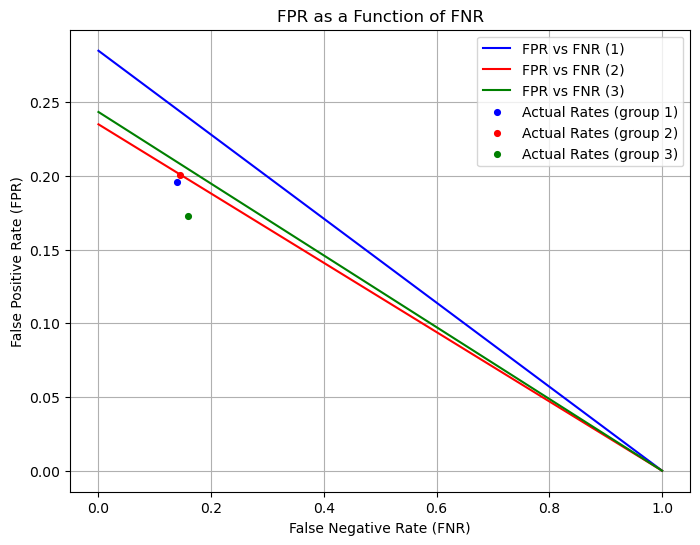

In [57]:
p1 = y_test[group_test==1].mean()    # Prevalence
p2 = y_test[group_test==2].mean()
p3 = y_test[group_test>=3].mean()

min_ppv = precision_score(y_test[group_test==2], y_hat[group_test==2]) # Lowest observed PPV was for black respondents

def compute_fpr(fnr, p, ppv):
    return (p / (1 - p)) * ((1 - ppv) / ppv) * (1 - fnr) # Equation 2.6

fnr_values = np.linspace(0, 1, 100)

fpr_values_1 = compute_fpr(fnr_values, p1, min_ppv)
fpr_values_2 = compute_fpr(fnr_values, p2, min_ppv)
fpr_values_3 = compute_fpr(fnr_values, p3, min_ppv)

plt.figure(figsize=(8, 6))
plt.plot(fnr_values, fpr_values_1, label='FPR vs FNR (1)', color='blue')
plt.plot(fnr_values, fpr_values_2, label='FPR vs FNR (2)', color='red')
plt.plot(fnr_values, fpr_values_3, label='FPR vs FNR (3)', color='green')

plt.scatter(fnr1, fpr1, color='blue', zorder=3, s=17, label="Actual Rates (group 1)")
plt.scatter(fnr2, fpr2, color='red', zorder=3, s=17, label="Actual Rates (group 2)")
plt.scatter(fnr3, fpr3, color='green', zorder=3, s=17, label="Actual Rates (group 3)")

plt.xlabel('False Negative Rate (FNR)')
plt.ylabel('False Positive Rate (FPR)')
plt.title('FPR as a Function of FNR')
plt.grid(True)
plt.legend()
plt.show()


Based on this chart, if we want the false positive rate to be equal among all groups, we would have to increase the false negative rate of group 2 to around 27-28%, at which point the actual rate for group 2 would have a matching false positive rate with group 3. Seeing as it currently sits at around 14%, this is a substantial increase, almost doubling the false negative rate. For group 1, the increase would be slightly less significant, as it sits at a lower initial false positive rate, though it would still nearly double. While this solution may decrease the disparate outcomes generated by the model, it would come at a substantial cost in accuracy. There may not be an effective means of correcting this bias without introducing substantial error rates for the model.

# Discussion

1. What groups of people could stand to benefit from a system that is able to predict the label you predicted? For example, what kinds of companies might want to buy your model for commercial use?

This model, which predicts the employment status of an individual based on metrics of their life, could be used by a broad range of companies-- essentially any company which is looking to hire people from the general public. When screening applicants, they could feed a given applicant's information to the model, and take a look at its prediction. Obviously, the companty is not necessarily interested in learning the current employment status of the candidate, but if the model predicted that the candidate is currently employed, that may suggest that they are a good choice for the company to hire. This is dangerous, as the company may not understand the model's reasoning for its predictions, and the model may exhibit bias towards certain groups rather than others, which creates an unfair scenario for job seekers.

2. Based on your bias audit, what could be the *impact* of deploying your model for large-scale prediction in commercial or governmental settings?

Given my bias audit, there are potential disparate impacts for certain groups if this model were to be used in a scenario like the one described above. While error rates between groups were relatively close, and the model was approximately calibrated, the positive predictive value was lower for black respondents than respondents of other racial groups. This suggests that black respondents are over-predicted to be employed when compared with white respondents. Depending on how that result was used, this could lead to inaccurate hiring procedures at a company, or, if used in a governmental setting, could lead to inaccurate predictions regarding employment rates. If employment rates for black people were systematically overpredicted by the government, for example, they may be granted less access to unemployment programs or benefits. 

3. Based on your bias audit, do you feel that your model displays problematic bias? What kind (calibration, error rate, etc)?

While the bias audit did reveal small discrepancies between categories, it is unclear whether this bias is problematic. Without a clear understanding of how the model would be used, as well as whether or not the differences between categories are statistically significant, it is difficult to evaluate whether the bias displayed is problematic or not. The category with the most potential to be problematic was positive predictive value, as the scenario above shows how the 4% discrepancy between white respondents and black respondents could cause harm. However, given the model's relatively even accuracy, and limited displays of bias, I find it unlikely that the model is inherently problematic-- though it could be used in problematic ways.

4. Beyond bias, are there other potential problems associated with deploying your model that make you uncomfortable? How would you propose addressing some of these problems?

The main issue I see with deploying a model like this is that the prediction it makes is not useful in and of itself, and the sorts of things for which it could be useful are things which I believe automated decision systems should not be handling. In the employment case, hiring processes should be carried out by humans, as reducing a human to a set of features does not give a fair and accurate picture of how that person would be in the workplace. In the governmental setting, predictions should not be used as any form of justification for legislation-- hard data should be used. I believe the most accurate way to address this concern is that machine learning models should only be used in cases where the computational problem at hand is clear, and has relatively low stakes. For example, blog post one on classifying penguins presents an example where the algorithm has relatively low potential to cause societal harm, and has innate utility in allowing someone to predict a species without actually having taken a look at the animal in question. These applications are where machine learning is strong, as the data on which the model is trained, as well as the predictions it makes, have little potential to introduce bias.